# Load and extract time series data

Gareth Funning, University of California, Riverside

An attempt to use MintPy functions to read in and manipulate InSAR time series. Wish me luck!

# 1. Dependencies and functions

The dependencies are the same as those that MintPy needs $-$ so make sure they are installed!

In [3]:
# let's start with some dependencies 
# (needless to say if they are not installed, jupyter will be sad)
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import dateutil
from osgeo import gdal, osr
from mintpy.utils import readfile, utils as ut

In [4]:
# here is little function to find the nearest neighbor to a value in an array
# (minimal alteration from stack overflow)
def closest(lst, K):  
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx

## 2. Load in and crop the data

The first step is to read in the data. Here we are using data from MintPy, although this ought to work for other datasets too. Each MintPy file contains a mixture of data layers ('subdatasets') and metadata information ('attributes') $-$ and we want both, ideally. 

This is a bit fiddly... we need to first read the attributes for each track in turn, to figure out the file dimensions and coordinates. Then we want load in multiple data layers from multiple files, and crop them to the same dimensions. Reading the attributes is easiest using one of the MintPy utilities, and we'll use Gdal for the actual data loading. The data files are HDF5 format, which is versatile, but potentially very complicated! 

The file 'timeseries.h5' for each track contains multiple subdatasets. By default the 'readfile.read' function reads in the 'timeseries' subdataset, which is a 3D array, with each layer representing cumulative displacement at each successive epoch.

It also contains a 'date' subdataset, which we load in a bit of a roundabout way (not sure if there is a better way?)


In [26]:
# for MintPy h5 files
# some file locations, names and details
datadir='./geo/'

# define your crop area (set to zeros to use file bounds)
crop_minx=0
crop_maxx=0
crop_maxy=0
crop_miny=0

# MintPy filenames
tsfile='geo_timeseries_ERA5_demErr.h5'

# ------
# we begin with the descending data

# read in data and metadata for the descending data
print('reading data from input file '+datadir+tsfile)
data, atr = readfile.read(datadir+tsfile, datasetName='timeseries')
print('reading slice list')
slicelist = readfile.get_slice_list(datadir+tsfile)
datelist =  [entry[11:19] for entry in slicelist]

# extract lat/lon information from the attributes
lat0 = float(atr['Y_FIRST']);  lat_step = float(atr['Y_STEP']);  lat_num = int(atr['LENGTH'])
lon0 = float(atr['X_FIRST']);  lon_step = float(atr['X_STEP']);  lon_num = int(atr['WIDTH'])
lat1 = lat0 + lat_step * lat_num
lon1 = lon0 + lon_step * lon_num
lats, lons = np.mgrid[lat0:lat1:lat_num*1j,
                      lon0:lon1:lon_num*1j]

# find the crop extents
if crop_minx!=0:
    mincol=closest(lons[0], crop_minx)
else:
    mincol=0
    crop_minx=lon0

if crop_maxx!=0:
    maxcol = closest(lons[0], crop_maxx)
else:
    maxcol=lon_num
    crop_maxx=lon1
    
if crop_maxy!=0:
    maxrow=closest(lats[:,0], crop_miny)
else:
    maxrow=lat_num
    crop_maxy=lat0

if crop_miny!=0:
    minrow = closest(lats[:,0], crop_maxy)
else: 
    minrow=0
    crop_miny=lat1
    
# optional bodge
#maxcol+=1
#maxrow+=1

# and crop the array to them
print('cropping to specified dimensions')
cropdata=data[:,minrow:maxrow,mincol:maxcol]
nrows = cropdata[0,:,0].size
ncols = cropdata[0,0,:].size

# make a new coordinate system
xx=np.linspace(crop_minx,crop_maxx,ncols)
yy=np.linspace(crop_maxy,crop_miny,nrows)
X, Y = np.meshgrid(xx,yy)

reading data from input file ./geo/geo_timeseries_ERA5_demErr.h5
reading slice list
cropping to specified dimensions


## 3. Extract a cumulative displacement time slice

Each layer of the 3D array containing the time series is a time slice of the cumulative displacement at the corresponding epoch. We want to look at these! And we can...

Extracting displacements from epoch 148 (20230130)


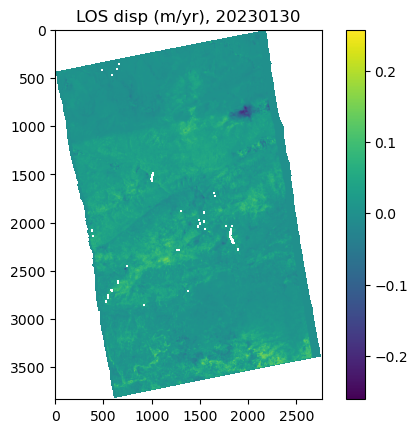

In [30]:
# extract a slice of your timeseries

# choose an epoch
epoch=148
print('Extracting displacements from epoch {0:d} ({1:s})'.format(epoch,datelist[epoch]))
cumu_disp=cropdata[epoch,:,:].squeeze()

# let's plot the cumulative displacement data
fig1, ax1 = plt.subplots()                       # initiate a matplotlib plot
im1 = ax1.imshow(cumu_disp)                         # plot displacements
ax1.set_title('LOS disp (m/yr), {0:s}'.format(datelist[epoch]))
jnk=fig1.colorbar(im1)    

In [52]:
# output yer time slice as a geotiff

# output filename
outdata='cumu_disp_' + datelist[epoch]

# try to write out the cumulative displacement data in GeoTiff format
driver = gdal.GetDriverByName("GTiff")

outgrd = driver.Create(outdata+'.tif', ncols, nrows, 1, gdal.GDT_Float32)
outgrd.SetGeoTransform((crop_minx, lon_step, 0, crop_maxy, 0, lat_step))

outgrdSRS = osr.SpatialReference()
outgrdSRS.ImportFromEPSG(4326)
outgrd.SetProjection(outgrdSRS.ExportToWkt())

outband = outgrd.GetRasterBand(1)
outband.WriteArray(cumu_disp,0,0)
outband.FlushCache()                 # need this to actually write anything!
outband.SetNoDataValue(0)
outgrd = None
del outgrd, outband


## 4. Time series double-differencing

One thing that could help with data analysis is double-differencing $-$ this cancels out common-mode signals and might isolate the deformation signal you are looking for. (The operative word is 'might'.) 

In [22]:
# find the two sample points

# this is the reference point that we hold fixed (on one side of a fault, say)
x1=38.772622
y1=38.217500

# and this is the point that is moving, relatively speaking
x2=38.796875
y2=38.193072


# how many additional points to average on either side?
sample_buffer=3

# find the appropriate location in the data for both sample points
col_x1 = closest(xx, x1)
col_x2 = closest(xx, x2)
row_y1 = closest(yy, y1)
row_y2 = closest(yy, y2)

# now use the magic of numpy to average over your buffered window of points for each epoch

# average your first sample point, over an area of pixels, at each time step
ts1=np.nanmean(cropdata[:,row_y1-sample_buffer:row_y1+sample_buffer,col_x1-sample_buffer:col_x1+sample_buffer],
               axis = (1,2))
# and the second...
ts2=np.nanmean(cropdata[:,row_y2-sample_buffer:row_y2+sample_buffer,col_x2-sample_buffer:col_x2+sample_buffer],
               axis = (1,2))

# note: you can also try taking the median instead if you are feeling it


# ...and then difference them!
tsdiff=ts2-ts1


To plot these or use them, you need to attach time data to them. We already extracted the dates in string, YYYYMMDD, form, now we just have to use them... and it turns out there are a couple of common libraries that you can use to do that $-$ 'dateutil' and 'datetime'.

In [23]:
# sort out your time axis

# start with some blank arrays
epoch_datetime=[]
epoch_ndays=[]
epoch_dyears=[]

# loop through, convert to datetime format and add to the list
for date_string in datelist:
    temp_datetime=dateutil.parser.parse(date_string)   # well, that's clever
    epoch_datetime.append(temp_datetime)
    
# if you prefer time in days
for date in epoch_datetime:
    temp_ndays=date-epoch_datetime[0]              # this makes a 'timedelta' object
    epoch_ndays.append(temp_ndays.days)                # and this extracts the days
    
# if you prefer time in decimal years
for date in epoch_datetime:
    # chunk of Stack Overflow 
    # https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years
    year=date.year
    startOfThisYear = datetime.datetime(year=year, month=1, day=1)
    startOfNextYear = datetime.datetime(year=year+1, month=1, day=1)
    
    yearElapsed = (date-startOfThisYear).days
    yearDuration = (startOfNextYear-startOfThisYear).days
    fraction = yearElapsed/yearDuration

    epoch_dyears.append(year+fraction)               

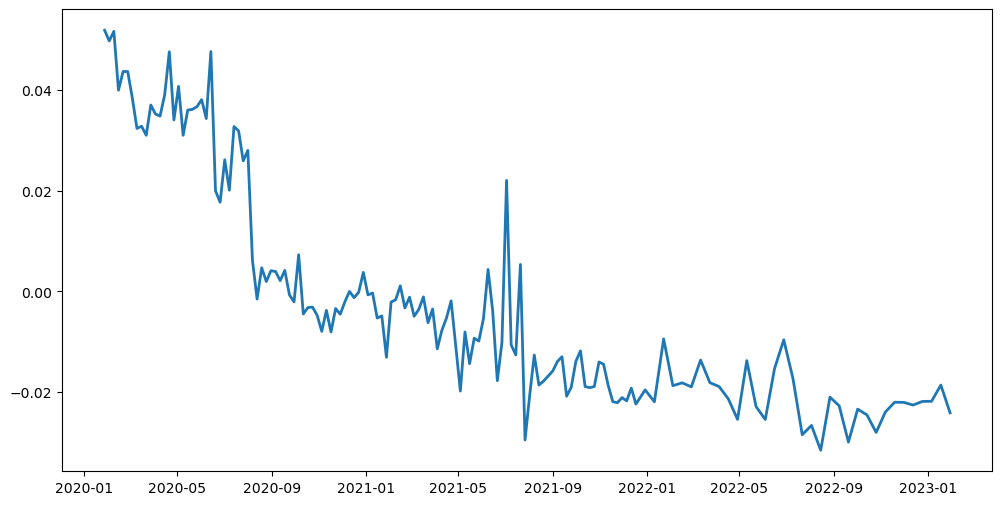

In [25]:
# let's plot some time series

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(epoch_datetime, tsdiff, linewidth=2.0)   # if you want dates
#ax.plot(epoch_ndays, tsdiff, linewidth=2.0)     # if you want number of days
#ax.plot(epoch_dyears, tsdiff, linewidth=2.0)   # if you want dates


#ax.scatter(epoch_datetime, tsdiff, s=5)   # if you want dates
#ax.scatter(epoch_ndays, tsdiff, s=5)      # if you want number of days

plt.show()


In [68]:
# want to output these?

out_data=np.column_stack((epoch_dyears,epoch_ndays, ts1, ts2, tsdiff))
outfile='differential_timeseries'+".txt"
np.savetxt(outfile,out_data,fmt='%f %d %f %f %f')